In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import collections
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from azure.storage.blob import (
    BlockBlobService,
    ContainerPermissions,
)

In [2]:
accountName = "singlecelltest"
containerName = "test-nafis"
blobService = BlockBlobService(account_name=accountName, account_key=None, sas_token="1OxiRjWfUNYwfow1Jn5icGjwHrcfk%3D&sr=b")
blob = blobService.get_blob_to_path(containerName, "", "Data.tsv")
data = pd.read_csv("Data.tsv",sep='\t')

# 3D Scatterplot of cell types

Text(0.5,0,'Z Label')

/Users/Thenextbestthing/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


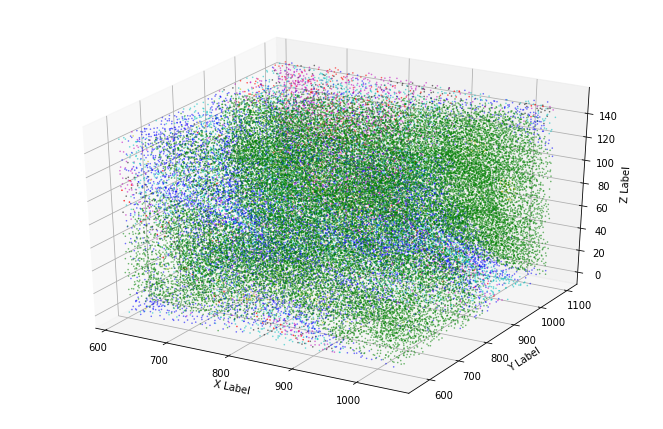

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(11.5, 7.5, forward=True)

t_cells = data[data['T Cell'] == 1]
basal_tc_cells = data[data['Basal TC'] == 1]
b_cells = data[data['B Cell'] == 1]
luminal_tc_cells = data[data['Luminal TC'] == 1]
macrophage_cells = data[data['Macrophage'] == 1]
granulocyte_cells = data[data['Granulocyte'] == 1]
stromal_cells = data[data['Stromal'] == 1]

ax.scatter(t_cells.X, t_cells.Y, t_cells.Z, c='r', s=0.4)
ax.scatter(basal_tc_cells.X, basal_tc_cells.Y, basal_tc_cells.Z, c='b', s=0.4, alpha=0.5)
ax.scatter(luminal_tc_cells.X, luminal_tc_cells.Y, luminal_tc_cells.Z, c='g', s=0.4, alpha=0.5)
ax.scatter(b_cells.X, b_cells.Y, b_cells.Z, c='m', s=0.4, alpha=0.5)
ax.scatter(macrophage_cells.X, macrophage_cells.Y, macrophage_cells.Z, c='y', s=0.4, alpha=0.5)
ax.scatter(stromal_cells.X, stromal_cells.Y, stromal_cells.Z, c='c', s=0.4, alpha=0.5)
ax.scatter(granulocyte_cells.X, granulocyte_cells.Y, granulocyte_cells.Z, c='k', s=0.4, alpha=0.5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# 2D Scatterplot of cell types

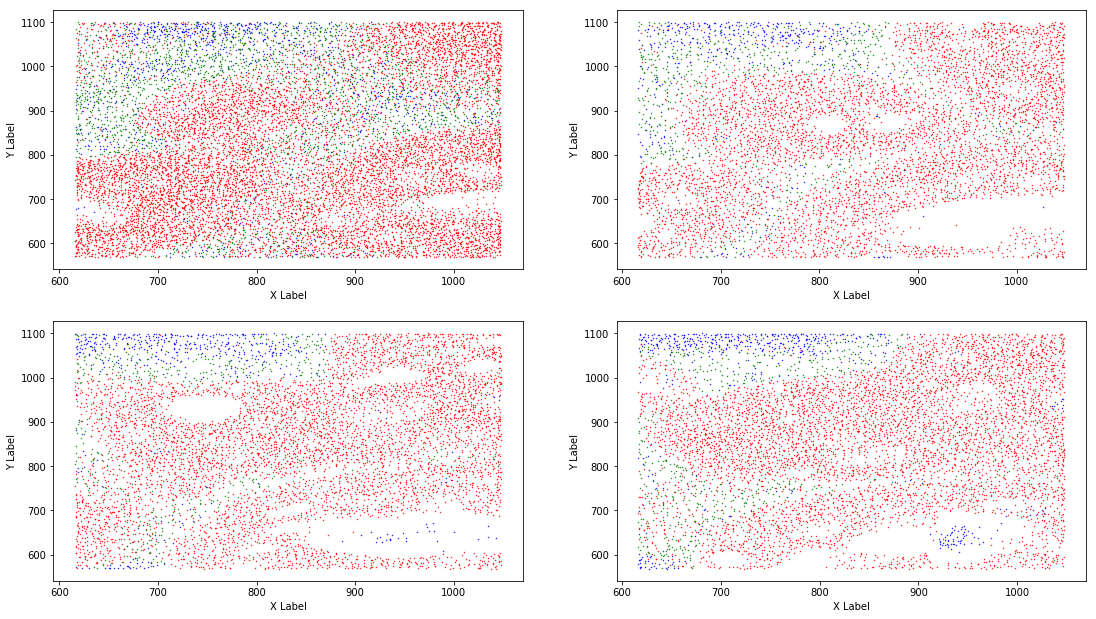

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.set_size_inches(18.5, 10.5, forward=True)

def plot_cells(z1,z2,ax):
    # Z falls between the range of z1 and z2
    z_cells = data[(data['Z'] > z1) & (data['Z'] < z2)]
    t_cells = z_cells[z_cells['T Cell'] == 1]
    basal_tc_cells = z_cells[z_cells['Basal TC'] == 1]
    b_cells = z_cells[z_cells['B Cell'] == 1]
    luminal_tc_cells = z_cells[z_cells['Luminal TC'] == 1]
    macrophage_cells = z_cells[z_cells['Macrophage'] == 1]
    granulocyte_cells = z_cells[z_cells['Granulocyte'] == 1]
    stromal_cells = z_cells[z_cells['Stromal'] == 1]
    # Immmune cells are blue
    ax.scatter(b_cells.X,b_cells.Y, c='b', s=.2)
    ax.scatter(t_cells.X,t_cells.Y, c='b', s=.2)
    ax.scatter(macrophage_cells.X,macrophage_cells.Y, c='b', s=.2)
    ax.scatter(granulocyte_cells.X,granulocyte_cells.Y, c='b', s=.2)
    # Tumor Cells are red
    ax.scatter(luminal_tc_cells.X,luminal_tc_cells.Y, c='r', s=.2)
    ax.scatter(basal_tc_cells.X,basal_tc_cells.Y, c='r', s=.2)
    # Stromal Cells green
    ax.scatter(stromal_cells.X,stromal_cells.Y,c='g',s=.2)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    
plot_cells(10,50,ax1)
plot_cells(50,70,ax2)
plot_cells(70,90,ax3)
plot_cells(100,120,ax4)

# N-nearest neighbours of different cell types

In [5]:
# Number of nearest neighbours = 10
n_neighbors = 10
# Fit training set 
X =  data[['X','Y','Z']].values[:]
X = np.array((X),dtype=float)
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(np.array((data['X'].values[:],data['Y'].values[:],data['Z'].values[:])).T)

In [6]:
cell_types = ['T Cell','Basal TC','B Cell','Luminal TC','Macrophage','Granulocyte','Stromal']
class_data = data.set_index(['X', 'Y', 'Z'])[cell_types].stack()
class_data = class_data[class_data == 1]
class_data.index.names = 'X', 'Y', 'Z', 'cell_type'
class_data = class_data.reset_index()[['X', 'Y', 'Z', 'cell_type']]
data = data.merge(class_data, how='left')

In [7]:
results = data['cell_type'].values[indices]
results = pd.DataFrame(results, index=data['cell_type'].values[:])
results['cell_idx'] = range(results.shape[0])
results.index.name = 'cell_type'
results = results.set_index('cell_idx', append=True).stack().rename('neighbour_cell_type').reset_index()[['cell_idx', 'cell_type', 'neighbour_cell_type']]
results['neighbour_idx'] = range(results.shape[0])
exclude = results[results['cell_type'] == results['neighbour_cell_type']].groupby('cell_idx').first()[['neighbour_idx']]
exclude['is_excluded'] = True
results = results.merge(exclude, how='left').fillna(False)
results = results[~results['is_excluded']]


# Factorplot of 10-nearest neighbours of different cell types

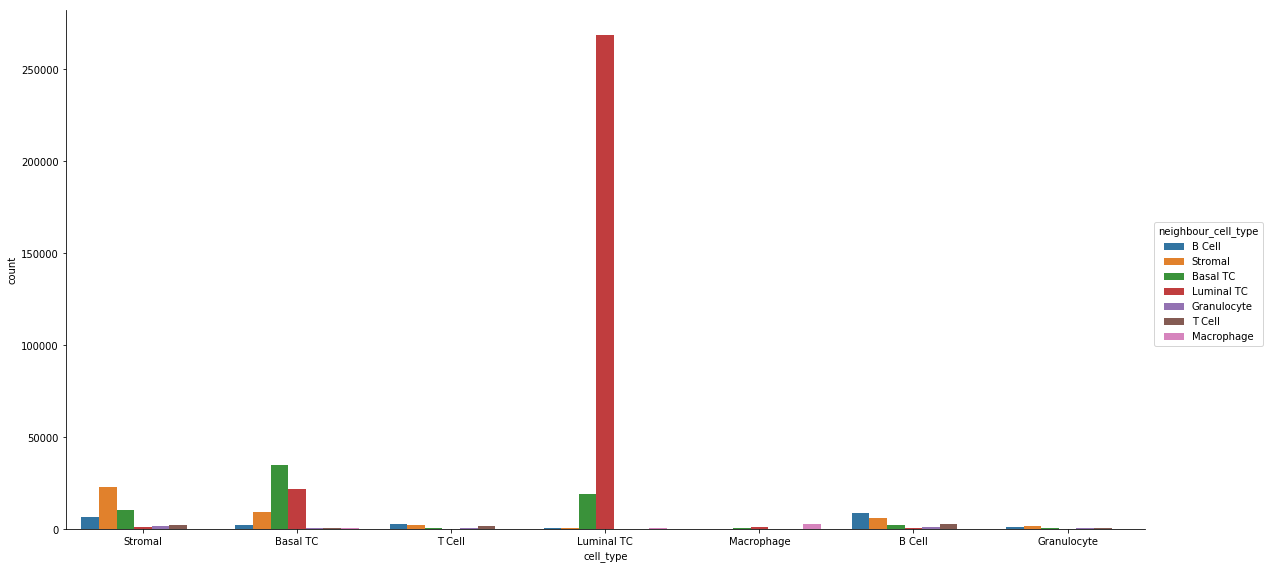

In [8]:
seaborn.factorplot(x='cell_type',hue='neighbour_cell_type',kind='count', data=results, aspect=2, size=8)